NAME: -VEMULA KASINATH

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
import math
from scipy.stats import norm
from scipy.stats import kruskal
from scipy.stats import kstest
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_application_train():
    data = pd.read_csv("/content/diabetes.csv")
    return data

df = load_application_train()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Exploratory Data Analysis

In [3]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

def cat_summary(dataframe, col_name, plot=False):

    if dataframe[col_name].dtypes == "bool":
        dataframe[col_name] = dataframe[col_name].astype(int)
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)
    else:
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)


def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def check_dataframe(dataframe, head=5):
    print("##### Shape #####")
    print(dataframe.shape)

    print("\n##### Types #####")
    print(dataframe.dtypes)

    print("\n##### Tail #####")
    print(dataframe.tail(head))

    print("\n##### Head #####")
    print(dataframe.head(head))
    print("\n##### Null Analysis #####")
    print(dataframe.isnull().sum())

    print("\n##### Quantiles #####")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)



def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [4]:
check_dataframe(df)

##### Shape #####
(768, 9)

##### Types #####
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

##### Tail #####
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
763                     0.171   63        0  
764                     0.340   27        0  
765            

In [5]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [6]:
print("Categorical column names: {}".format(cat_cols))
print("Numerical column names: {}".format(num_cols))

Categorical column names: ['Outcome']
Numerical column names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


   Outcome      Ratio
0      500  65.104167
1      268  34.895833
##########################################


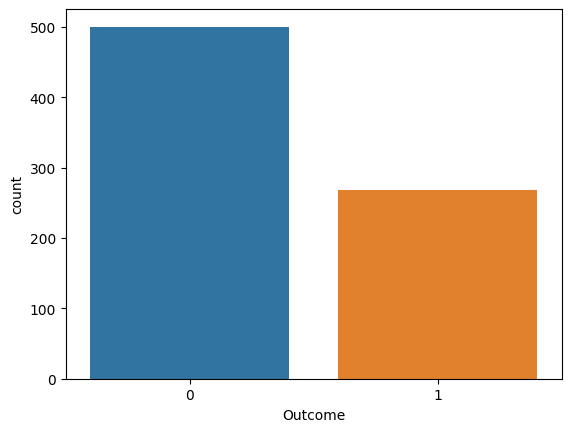

In [7]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
1%         0.000000
5%         0.000000
10%        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


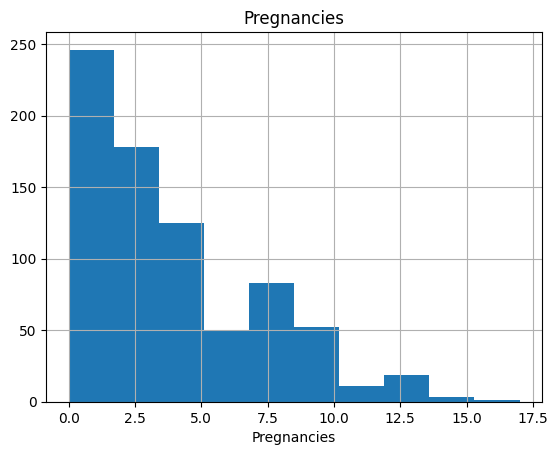

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
1%        57.000000
5%        79.000000
10%       85.000000
25%       99.000000
50%      117.000000
75%      140.250000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


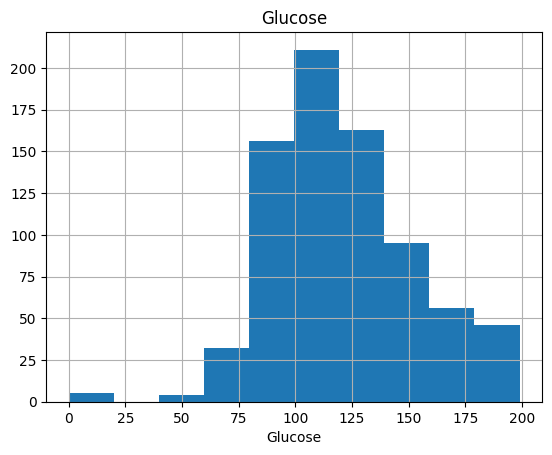

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
1%         0.000000
5%        38.700000
10%       54.000000
25%       62.000000
50%       72.000000
75%       80.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


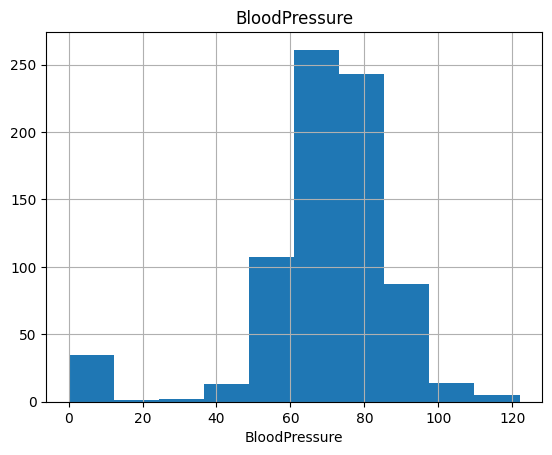

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
1%         0.000000
5%         0.000000
10%        0.000000
25%        0.000000
50%       23.000000
75%       32.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64


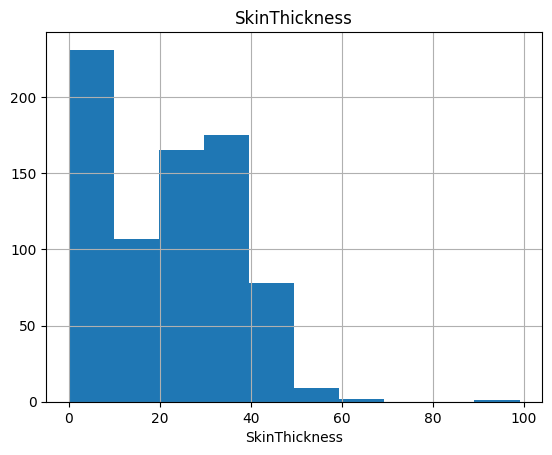

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
1%         0.000000
5%         0.000000
10%        0.000000
25%        0.000000
50%       30.500000
75%      127.250000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64


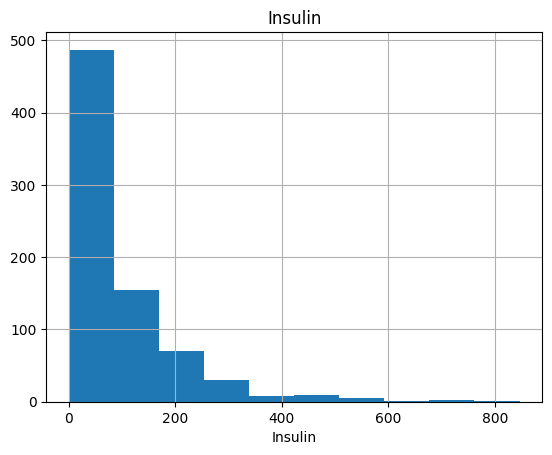

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
1%         0.000000
5%        21.800000
10%       23.600000
25%       27.300000
50%       32.000000
75%       36.600000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


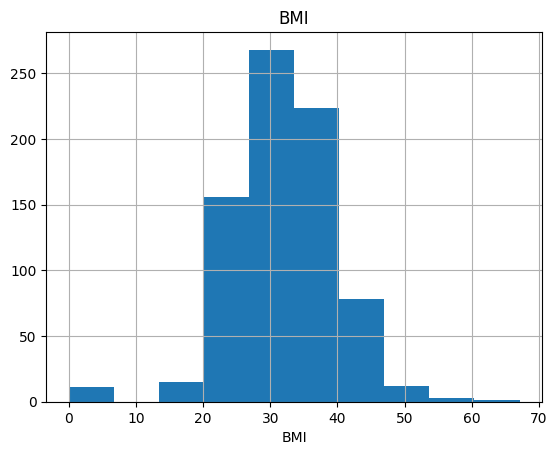

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
1%         0.094680
5%         0.140350
10%        0.165000
25%        0.243750
50%        0.372500
75%        0.626250
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


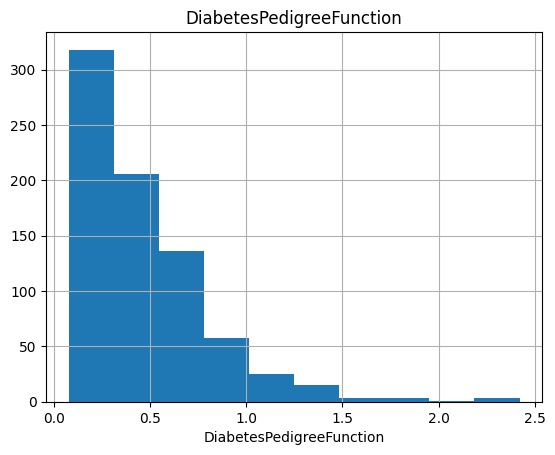

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
1%        21.000000
5%        21.000000
10%       22.000000
25%       24.000000
50%       29.000000
75%       41.000000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


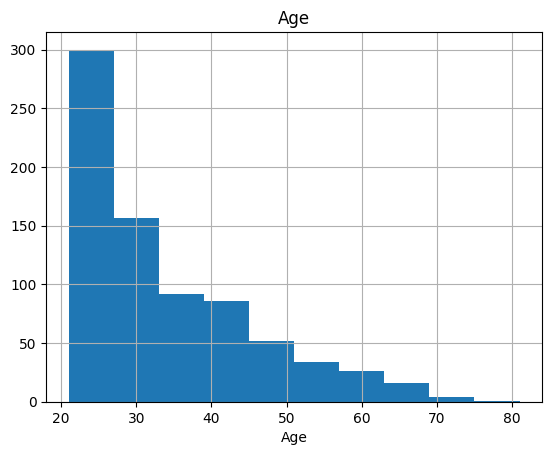

In [8]:
for col in num_cols:
    num_summary(df, col, plot=True)

In [9]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




In [10]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Outcome", col)

         TARGET_MEAN
Outcome             
0                0.0
1                1.0




In [11]:
for col in df.columns:
    low, up = outlier_thresholds(df, col)
    print(f"Up and Low limit for '{col}': {low}, {up}")

Up and Low limit for 'Pregnancies': -6.5, 13.5
Up and Low limit for 'Glucose': 37.125, 202.125
Up and Low limit for 'BloodPressure': 35.0, 107.0
Up and Low limit for 'SkinThickness': -48.0, 80.0
Up and Low limit for 'Insulin': -190.875, 318.125
Up and Low limit for 'BMI': 13.35, 50.550000000000004
Up and Low limit for 'DiabetesPedigreeFunction': -0.32999999999999996, 1.2
Up and Low limit for 'Age': -1.5, 66.5
Up and Low limit for 'Outcome': -1.5, 2.5


In [12]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies True
Glucose True
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True


<Axes: >

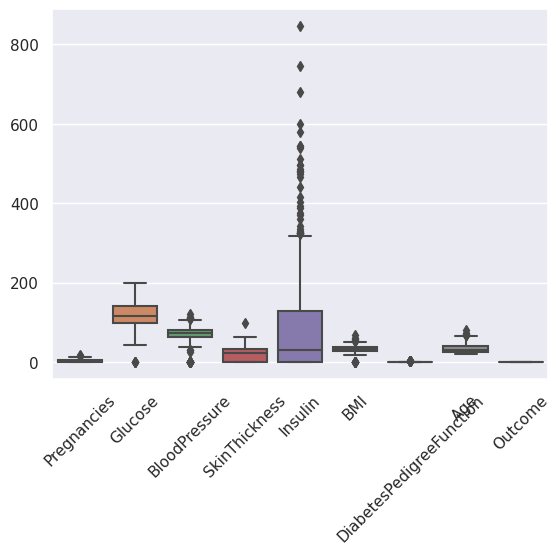

In [13]:
sns.set()
plt.xticks(rotation=45)
sns.boxplot(data=df)

In [14]:
for col in num_cols:
    print(f"grab_outliers '{col}': {grab_outliers(df, col)}")

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
88            15      136             70             32      110  37.1   
159           17      163             72             41      114  40.9   
298           14      100             78             25      184  36.6   
455           14      175             62             30        0  33.6   

     DiabetesPedigreeFunction  Age  Outcome  
88                      0.153   43        1  
159                     0.817   47        1  
298                     0.412   46        1  
455                     0.212   38        1  
grab_outliers 'Pregnancies': None
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
75             1        0             48             20        0  24.7   
182            1        0             74             20       23  27.7   
342            1        0             68             35        0  32.0   
349            5        0             80             32        0  41.

In [15]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [16]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


Empty DataFrame
Columns: [n_miss, ratio]
Index: []


<Axes: >

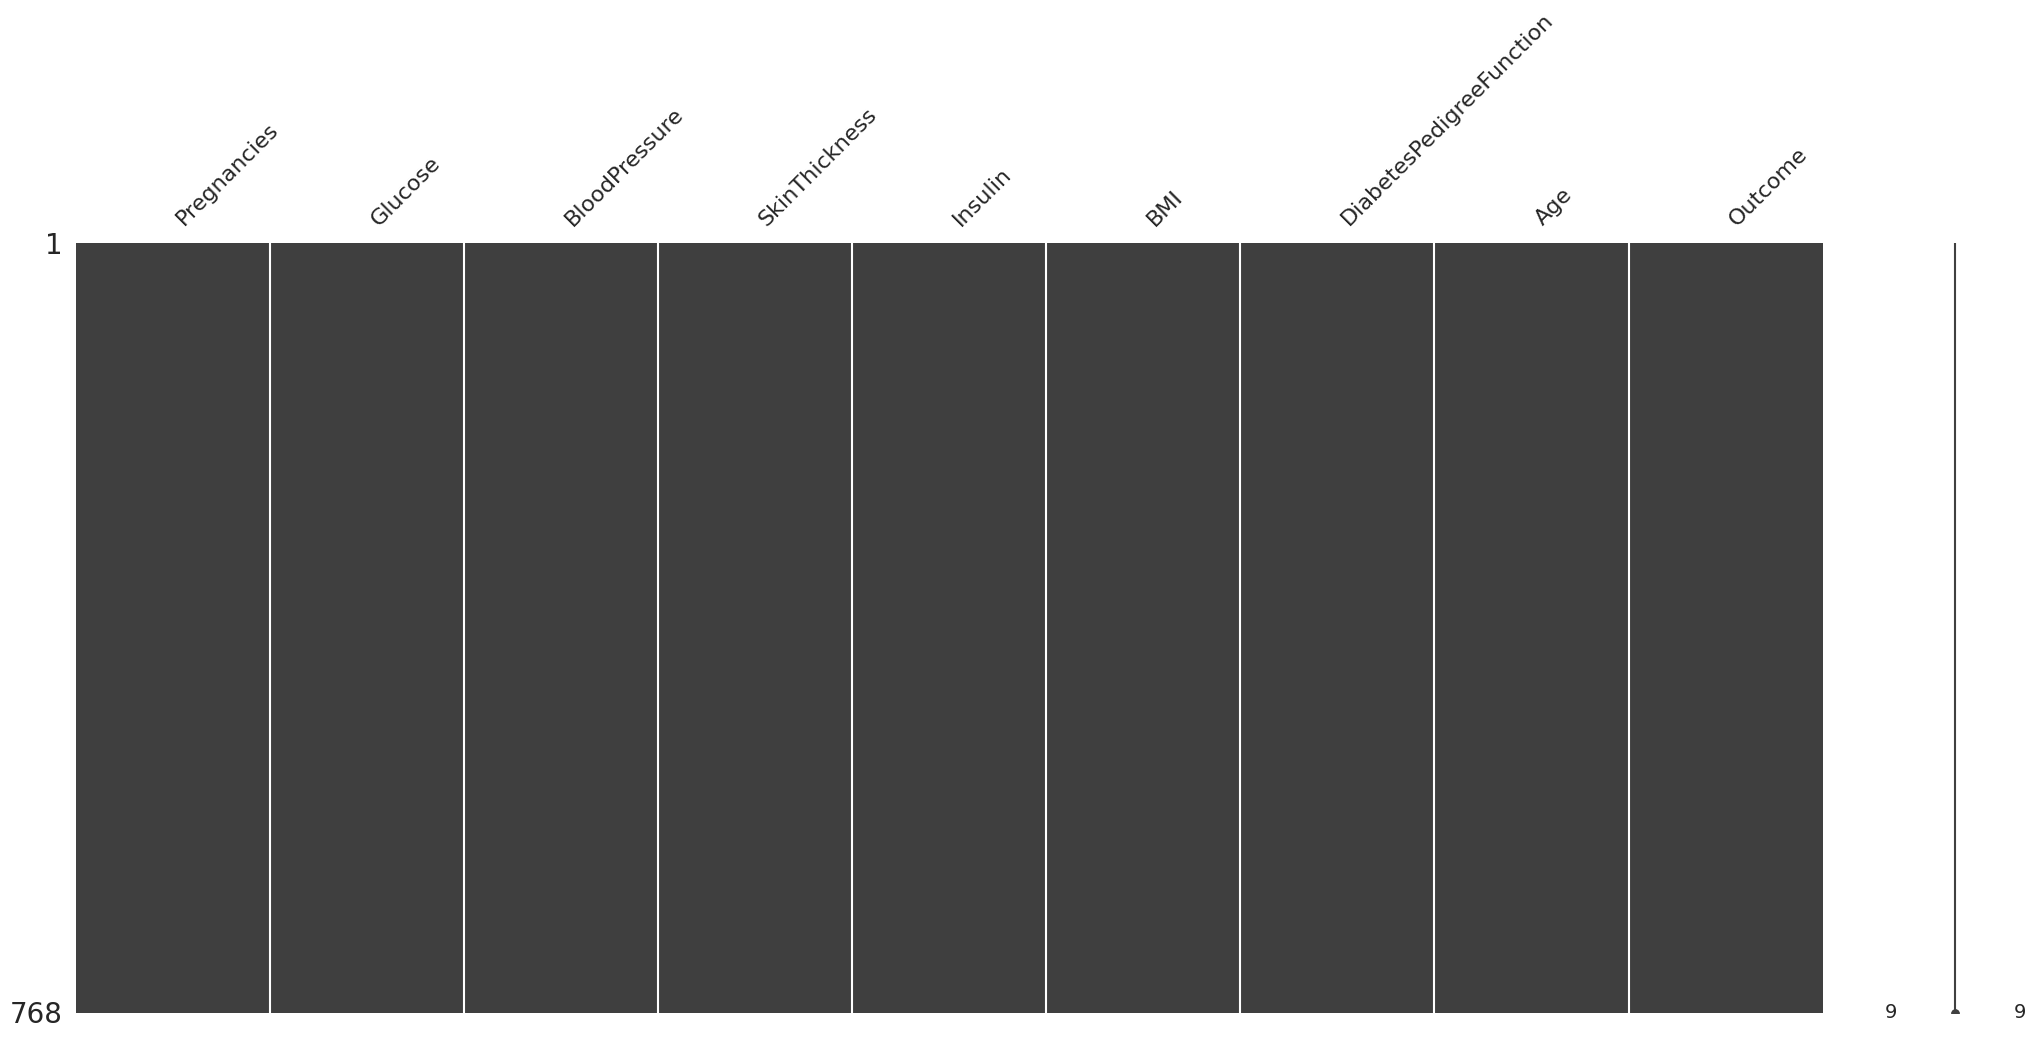

In [17]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df, True)
msno.matrix(df)

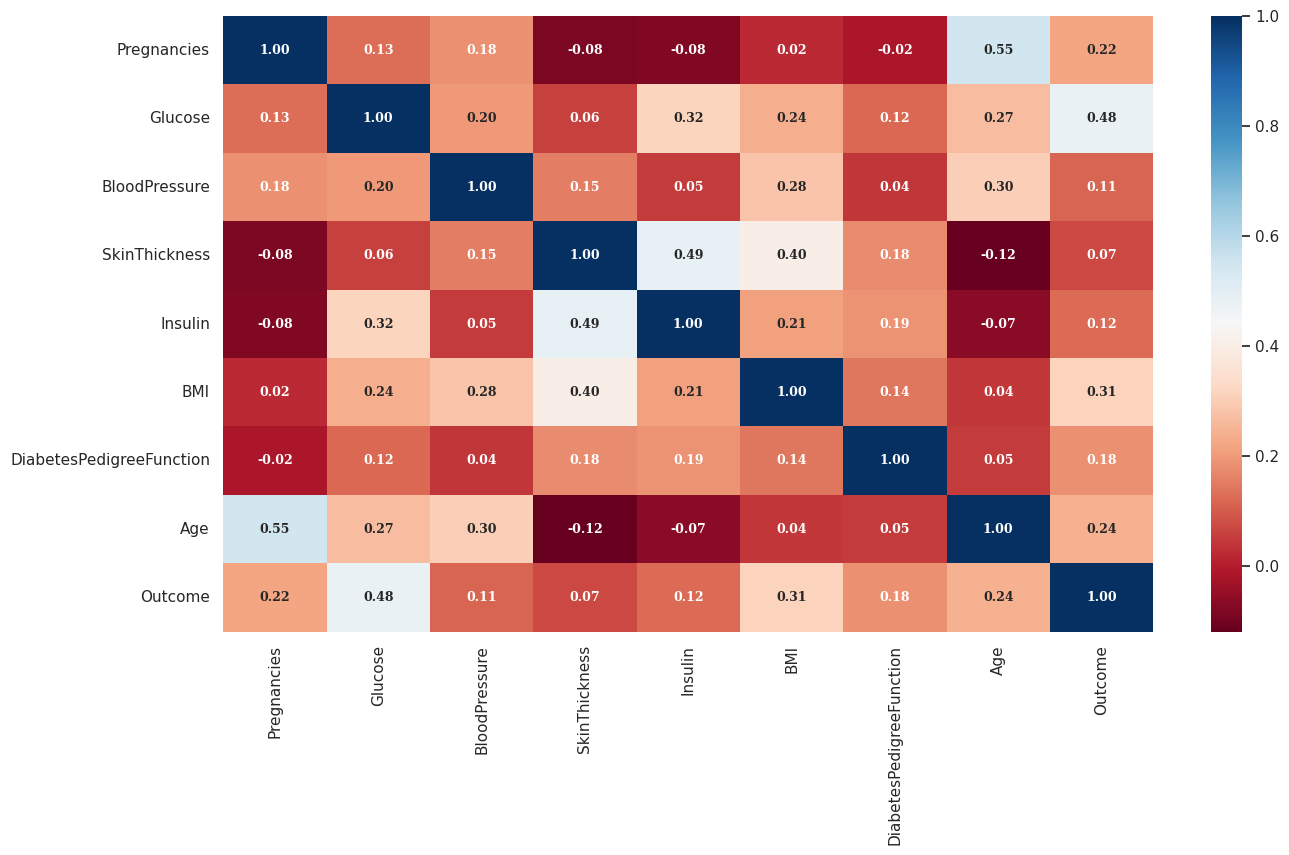

In [18]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(method= 'pearson'),annot=True,fmt=".2f",
                cmap="RdBu",
                annot_kws={
                       "fontsize":9,
                       "fontweight":"bold",
                       "fontfamily":"serif"});

In [19]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

high_correlated_cols(df)

[]

In [20]:
X = df.drop("Outcome" , axis = 1)
y = df["Outcome"]
### Verinin Test ve Train olarak ayrılması
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=46)

In [21]:
## Random Forest İle Model Kurma Ve Tahmin İşlemi
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 3)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 3)}")

Accuracy: 0.745
Auc: 0.719
